# NEXRAD Demo

This is a very crude demo of how to access the NEXRAD data.

In [1]:
from datetime import datetime, timedelta
import os

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from util.nexrad.namingconventions import get_nc_fname

First we need to specify where the data is located.
Depending on how you mount the data directory, this may be different.

In [2]:
RDF_DIR = "/home/jd82/RDF/jd82"
os.path.isdir(RDF_DIR)

True

Next we specify the times we want to plot.
Let's look at Hurricane Harvey.

In [3]:
t_start = datetime(2017, 8, 25, 0)
t_end = datetime(2017, 8, 30, 23)
t_all = pd.date_range(start=t_start, end=t_end, freq="H")

/tmp/ipykernel_73774/3502822580.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_all = pd.date_range(start=t_start, end=t_end, freq="H")


Now leverage the built-in package to get the filename corresponding to each given hour time stamp

In [4]:
all_files = [get_nc_fname(t, dirname=os.path.join(RDF_DIR, "NEXRAD")) for t in t_all]
all_files = [f for f in all_files if os.path.isfile(f)]
len(all_files)

144

Now read them all in using the power of xarray

In [5]:
ds = xr.open_mfdataset(all_files).rename({"param9.6.209": "precip_mm"})["precip_mm"]
ds

<xarray.DataArray 'precip_mm' (time: 144, alt: 1, lat: 3500, lon: 7000)> Size: 14GB
dask.array<concatenate, shape=(144, 1, 3500, 7000), dtype=float32, chunksize=(1, 1, 1, 7000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1kB 2017-08-25 ... 2017-08-30T23:00:00
  * lon      (lon) float64 56kB 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0
  * lat      (lat) float64 28kB 54.99 54.98 54.97 54.96 ... 20.02 20.01 20.0
  * alt      (alt) float64 8B 0.0
Attributes:
    param:    9.6.209

We don't need to look at all of CONUS, a small area is fine

In [6]:
tx_precip = ds.sel(lon=slice(255, 275), lat=slice(40, 20))
tx_precip

<xarray.DataArray 'precip_mm' (time: 144, alt: 1, lat: 2000, lon: 2000)> Size: 2GB
dask.array<getitem, shape=(144, 1, 2000, 2000), dtype=float32, chunksize=(1, 1, 1, 2000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1kB 2017-08-25 ... 2017-08-30T23:00:00
  * lon      (lon) float64 16kB 255.0 255.0 255.0 255.0 ... 275.0 275.0 275.0
  * lat      (lat) float64 16kB 39.99 39.98 39.97 39.96 ... 20.02 20.01 20.0
  * alt      (alt) float64 8B 0.0
Attributes:
    param:    9.6.209

Now let's convert the daily data to hourly data.
Note the `.compute()` command, which forces the computer to read the actual data, rather than just the metadata (which is what it does by default).
This may take a while since the RDF is surprisngly slow!

In [7]:
daily_precip = tx_precip.groupby("time.date").sum().compute()
daily_precip

<xarray.DataArray 'precip_mm' (date: 6, alt: 1, lat: 2000, lon: 2000)> Size: 96MB
array([[[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]]],


       [[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
...
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]]],


       [[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 16kB 255.0 255.0 255.0 255.0 ... 275.0 275.0 275.0
  * lat      (lat) float64 16kB 39.99 39.98 39.97 39.96 ... 20.02 20.01 20.0
  * alt      (alt) float64 8B 0.0
  * date     (date) object 48B 2017-08-25 2017-08-26 ... 2017-08-29 2017-08-30
Attributes:
    param:    9.6.209

Now we can plot it using xarray's [built-in plotting](https://docs.xarray.dev/en/latest/user-guide/plotting.html#maps) to visualize

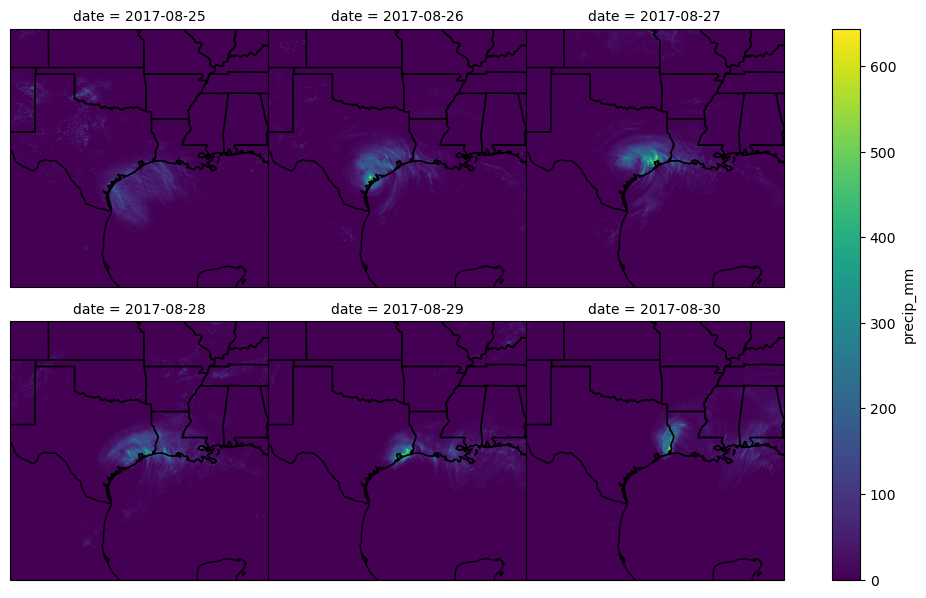

In [8]:
p = daily_precip.plot(
    col="date",
    col_wrap=3,
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    transform=ccrs.PlateCarree(),
)

for ax in p.axs.flat:
    ax.coastlines()
    ax.add_feature(feature.STATES)

plt.draw()